In [82]:

import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SPIKES_WINDOW_SIZE,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from alibi_detect.od import SpectralResidual
import matplotlib.pyplot as plt
import numpy as np

In [96]:
COMMODITY = "magnesium"

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH)

TRAIN_SIZE = 0.5

/Users/harshdeepsingh/ASU/Lab_V2/GSN/onr_price_prediction/analysis/build_data.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
/Users/harshdeepsingh/ASU/Lab_V2/GSN/onr_price_prediction/analysis/build_data.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)


In [97]:
od = SpectralResidual(
    threshold=1.,
    window_amp=20,
    window_local=20,
    padding_amp_method='reflect',
    padding_local_method='reflect',
    padding_amp_side='bilateral',
    n_est_points=10,
    n_grad_points=5
)

In [98]:
aggregated_df = data.copy()
X, y = data_processing.prepare_features_and_target(aggregated_df, 'Price', 'spikes')
X = X[1:]
y = y[1:]
time_sample = np.arange(0, len(X), 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=TRAIN_SIZE, shuffle=False)

In [99]:
#Infer threshold
od.infer_threshold(
    X_train,
    t = time_sample[:len(X_train)],
    threshold_perc=95
)

In [100]:
preds = od.predict(
    X_test,
    t = time_sample[len(X_train):],
    return_instance_score=True
)

In [101]:
#Number of instances detected as anomalies
print("Number of instances as anomalies:", (preds['data']['is_outlier'] == 1).sum()) 

Number of instances as anomalies: 14


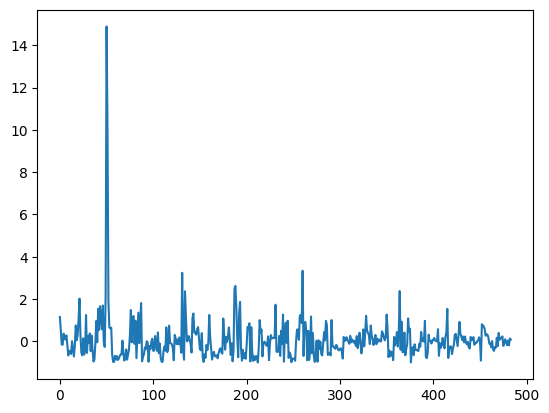

In [102]:
plt.plot(preds['data']['instance_score'])

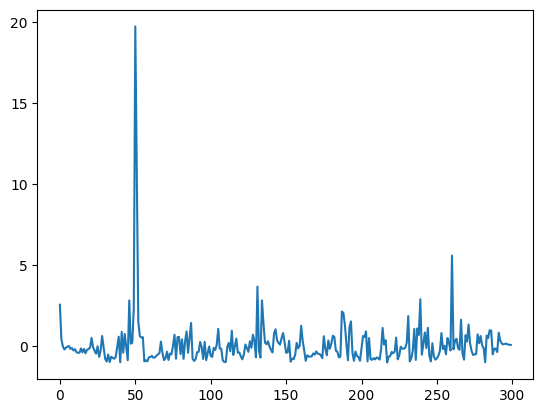

In [103]:
#Plot scores for first 300 instances
pred_temp = od.predict(
    X_test[:300],
    t = time_sample[len(X_train):len(X_train)+300],
    return_instance_score=True
)
plt.plot(pred_temp['data']['instance_score'])

In [104]:
spike_df = pd.DataFrame(preds['data']['is_outlier'])
spike_df.columns = ['spikes']

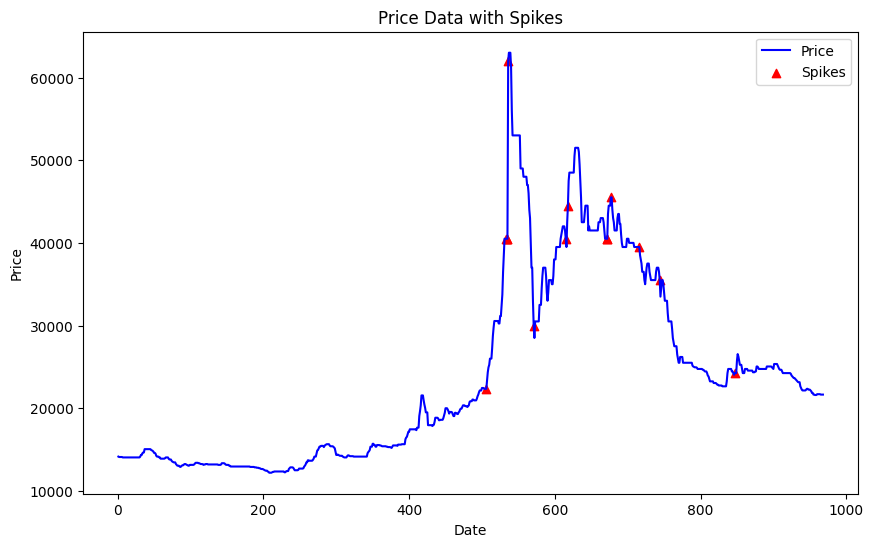

In [105]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = len(X_train) + spike_df[spike_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()